##### Importing libraries and framework

In [1]:
# Importing the necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Prepare the data

In [2]:
# Load the data from the CSV file into a DataFrame
data = pd.read_csv('datasets/listings_preprocessed.csv')

# Separate the input features (X) and target variable (y)
X = data.drop('price', axis=1)
y = data['price']

# Filter out non-numeric columns
numeric_columns = X.select_dtypes(include=['number']).columns
X_numeric = X[numeric_columns]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)

# One-hot encode categorical features
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Align the columns of the training and testing sets
X_train, X_test = X_train.align(X_test, join='left', axis=1)

# Fill missing values in the training set with the mean of each column
X_train.fillna(X_train.mean(), inplace=True)

# Fill missing values in the test set with the mean of the corresponding columns in the training set
X_test.fillna(X_train.mean(), inplace=True)

# Fill remaining NaN values with 0
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)


#### Predict the data

In [4]:
# Initialize the Random Forest Regressor with desired parameters
rf = RandomForestRegressor(n_estimators=100, random_state=42)  # You can customize the parameters as needed

# Train the model
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

#### Display MSE

In [9]:
# Calculate Mean Squared Error (MSE) as the evaluation metric
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 936893.4285033899


#### Plot the regression model

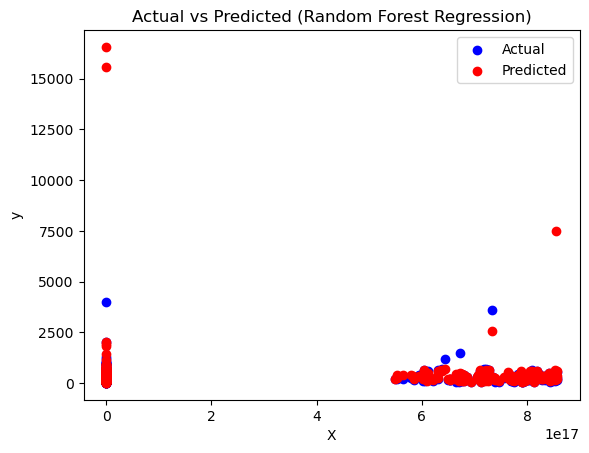

In [11]:
# Plot actual vs predicted values
plt.scatter(X_test['id'], y_test, color='blue', label='Actual')
plt.scatter(X_test['id'], y_pred, color='red', label='Predicted')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Actual vs Predicted (Random Forest Regression)')
plt.legend()
plt.show()
